# Fourier Basis EDMD + KSWGD on Torus T²

This notebook implements **Fourier Basis Extended Dynamic Mode Decomposition (EDMD)** combined with **KSWGD** on a **Torus manifold**.

## Key Differences from Kernel EDMD:
- Uses **explicit Fourier basis functions** instead of kernel methods
- Basis functions: $e^{i(k_\theta \theta + k_\phi \phi)}$ for $(k_\theta, k_\phi) \in \mathbb{Z}^2$
- Number of basis functions automatically chosen based on data
- Only top-K eigenvalues (excluding λ=1 and small values) are retained

## Torus Parametrization

The torus $T^2$ is embedded in $\mathbb{R}^3$ using angles $(\theta, \phi) \in [0, 2\pi)^2$:

$$
\begin{aligned}
x &= (R + r\cos\phi)\cos\theta \\
y &= (R + r\cos\phi)\sin\theta \\
z &= r\sin\phi
\end{aligned}
$$

- $R$: Major radius (center to tube center)
- $r$: Minor radius (tube radius)

## Exact SDE for Brownian Motion on Torus

**Stratonovich SDE** (pure diffusion, uniform invariant measure):
$$
d\theta = \frac{\sqrt{2}}{R + r\cos\phi} \circ dW_t^1, \quad
d\phi = \frac{\sqrt{2}}{r} \circ dW_t^2
$$

**Equivalent Itô SDE** (with Wong-Zakai correction):
$$
d\theta = \frac{\sin\phi}{r(R + r\cos\phi)^2} dt + \frac{\sqrt{2}}{R + r\cos\phi} dW_t^1, \quad
d\phi = \frac{\sqrt{2}}{r} dW_t^2
$$

The drift term in $\theta$ arises from the curvature of the torus - particles diffuse faster on the inner side (smaller circumference) than the outer side.

## 1. Import Libraries and Configuration

In [1]:
import numpy as np
from scipy.linalg import svd, eigh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time

# --------------- Optional GPU backend (CuPy) ---------------
# Note: For Fourier basis EDMD, GPU is optional (mainly for future optimization)
USE_GPU = False  # Fourier basis version runs on CPU
try:
    import cupy as cp  # type: ignore
    GPU_AVAILABLE = True
except Exception:
    cp = None  # type: ignore
    GPU_AVAILABLE = False

# NOTE: We no longer import grad_ker1 or K_tar_eval
# The Fourier basis EDMD uses explicit basis functions instead of kernels

print(f"[DEVICE] CPU mode (Fourier basis EDMD)")

[DEVICE] CPU mode (Fourier basis EDMD)


## 2. Define Timing and Progress Utility Functions

In [2]:
# ---------------- Timing / Progress Utilities ----------------
def _fmt_secs(s: float) -> str:
    s = max(0.0, float(s))
    h = int(s // 3600)
    m = int((s % 3600) // 60)
    sec = int(s % 60)
    if h > 0:
        return f"{h:02d}:{m:02d}:{sec:02d}"
    return f"{m:02d}:{sec:02d}"

def _print_phase(name: str, t_start: float) -> float:
    dt = time.time() - t_start
    print(f"[TIMER] {name}: {dt:.3f}s")
    return time.time()

_LAST_PROGRESS_LEN = 0
def _print_progress(curr: int, total: int, start_time: float, prefix: str = "") -> None:
    global _LAST_PROGRESS_LEN
    total = max(1, int(total))
    curr = min(max(0, curr), total)
    bar_len = 30
    filled = int(bar_len * curr / total)
    filled = min(filled, bar_len)
    bar = ("=" * filled) + (">" if filled < bar_len else "") + ("." * max(0, bar_len - filled - (0 if filled == bar_len else 1)))
    pct = 100.0 * curr / total
    elapsed = time.time() - start_time
    avg = elapsed / max(1, curr)
    eta = avg * (total - curr)
    msg = f"{prefix}[{bar}] {pct:5.1f}% | iter {curr}/{total} | elapsed {_fmt_secs(elapsed)} | eta {_fmt_secs(eta)}"
    prev = _LAST_PROGRESS_LEN
    clear = "\r" + (" " * prev) + "\r"
    print(clear, end="")
    print(msg, end="", flush=True)
    _LAST_PROGRESS_LEN = len(msg)

# Set random seed for reproducibility
np.random.seed(42)
_t = time.time()

## 3. Configuration Parameters

- `R`: Major radius of the torus (center to tube center)
- `r`: Minor radius of the torus (tube radius)
- `n`: Number of target sample points
- `d`: Embedding dimension (3 for torus in R³)
- `N_FOURIER_MODES`: Maximum Fourier mode order in each direction
- `N_MODES_RETAIN`: Number of modes to retain for DM and Koopman spectral decomposition

In [3]:
# ---------------- Torus Configuration ----------------
R = 2.0   # Major radius (center to tube center)
r = 0.8   # Minor radius (tube radius), must satisfy r < R

# ===== FOURIER BASIS CONFIGURATION =====
N_FOURIER_MODES = 5  # Maximum Fourier mode order in each direction (-N to N)
                       # Total number of basis functions: (2*N+1)^2 = 441 for N=10
N_MODES_RETAIN = 50   # Number of non-trivial modes to retain (excluding λ=1 and small ones)

# ===== PROJECTION SWITCH =====
USE_PROJECTION = False  # True: project particles back to torus after each step ("cheating")
                       # False: let KSWGD learn the manifold from data alone

# Number of target sample points
n = 5000

d = 3  # Embedding dimension (torus lives in R³)

print(f"[CONFIG] Torus parameters: R={R}, r={r}")
print(f"[CONFIG] Number of samples: n={n}")
print(f"[CONFIG] Fourier modes: -{N_FOURIER_MODES} to {N_FOURIER_MODES} → Total basis: {(2*N_FOURIER_MODES+1)**2}")
print(f"[CONFIG] Modes to retain (for DM and Koopman): {N_MODES_RETAIN}")
print(f"[CONFIG] USE_PROJECTION = {USE_PROJECTION}")

[CONFIG] Torus parameters: R=2.0, r=0.8
[CONFIG] Number of samples: n=5000
[CONFIG] Fourier modes: -5 to 5 → Total basis: 121
[CONFIG] Modes to retain (for DM and Koopman): 50
[CONFIG] USE_PROJECTION = False


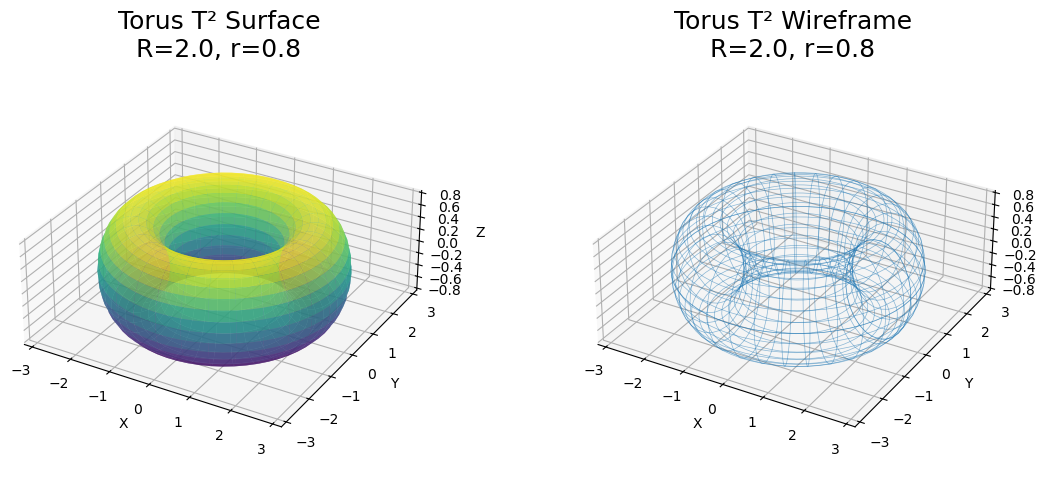

[INFO] Torus geometry: Major radius R=2.0, Minor radius r=0.8
[INFO] Torus extends from x,y ∈ [-2.8, 2.8], z ∈ [-0.8, 0.8]


In [4]:
# Visualize the torus surface
fig = plt.figure(figsize=(12, 5))

# Create mesh grid for torus surface
theta_mesh = np.linspace(0, 2 * np.pi, 60)
phi_mesh = np.linspace(0, 2 * np.pi, 30)
THETA, PHI = np.meshgrid(theta_mesh, phi_mesh)

# Parametric equations for torus
X_mesh = (R + r * np.cos(PHI)) * np.cos(THETA)
Y_mesh = (R + r * np.cos(PHI)) * np.sin(THETA)
Z_mesh = r * np.sin(PHI)

# Plot 1: Surface plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X_mesh, Y_mesh, Z_mesh, cmap='viridis', alpha=0.7, edgecolor='none')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f'Torus T² Surface\nR={R}, r={r}', fontsize=18)
ax1.set_box_aspect([1, 1, 0.4])

# Plot 2: Wireframe plot (shows structure better)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_wireframe(X_mesh, Y_mesh, Z_mesh, color='C0', alpha=0.5, linewidth=0.5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(f'Torus T² Wireframe\nR={R}, r={r}', fontsize=18)
ax2.set_box_aspect([1, 1, 0.4])

plt.tight_layout()
plt.show()

print(f"[INFO] Torus geometry: Major radius R={R}, Minor radius r={r}")
print(f"[INFO] Torus extends from x,y ∈ [{-(R+r):.1f}, {R+r:.1f}], z ∈ [{-r:.1f}, {r:.1f}]")

## 4. Torus Helper Functions

Define functions to:
1. Convert between angular coordinates $(\theta, \phi)$ and Cartesian $(x, y, z)$
2. Compute tangent vectors and normal vectors on the torus

In [5]:
def angles_to_cartesian(theta, phi, R, r):
    """
    Convert angular coordinates (theta, phi) to Cartesian (x, y, z).
    
    Parameters:
        theta: array of shape (n,) - angle around the major circle [0, 2π)
        phi: array of shape (n,) - angle around the minor circle [0, 2π)
        R: major radius
        r: minor radius
    
    Returns:
        X: array of shape (n, 3) - Cartesian coordinates
    """
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    return np.column_stack([x, y, z])

def cartesian_to_angles(X, R, r):
    """
    Convert Cartesian coordinates (x, y, z) back to angular (theta, phi).
    
    Parameters:
        X: array of shape (n, 3) - Cartesian coordinates
        R: major radius
        r: minor radius
    
    Returns:
        theta: array of shape (n,) - angle around major circle [0, 2π)
        phi: array of shape (n,) - angle around minor circle [0, 2π)
    """
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    theta = np.arctan2(y, x)
    theta = np.mod(theta, 2 * np.pi)  # Ensure [0, 2π)
    
    # Distance from z-axis
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(z, rho - R)
    phi = np.mod(phi, 2 * np.pi)  # Ensure [0, 2π)
    
    return theta, phi

def compute_torus_tangent_normal(theta, phi, R, r):
    """
    Compute unit tangent vectors and normal vector at each point on the torus.
    
    Returns:
        e_theta: (n, 3) unit tangent in theta direction
        e_phi: (n, 3) unit tangent in phi direction
        normal: (n, 3) outward unit normal
    """
    n_pts = len(theta)
    
    # Partial derivatives (not normalized)
    # ∂X/∂θ = (-(R + r cos φ) sin θ, (R + r cos φ) cos θ, 0)
    dx_dtheta = np.column_stack([
        -(R + r * np.cos(phi)) * np.sin(theta),
        (R + r * np.cos(phi)) * np.cos(theta),
        np.zeros(n_pts)
    ])
    
    # ∂X/∂φ = (-r sin φ cos θ, -r sin φ sin θ, r cos φ)
    dx_dphi = np.column_stack([
        -r * np.sin(phi) * np.cos(theta),
        -r * np.sin(phi) * np.sin(theta),
        r * np.cos(phi)
    ])
    
    # Normalize to get unit tangent vectors
    e_theta = dx_dtheta / (np.linalg.norm(dx_dtheta, axis=1, keepdims=True) + 1e-12)
    e_phi = dx_dphi / (np.linalg.norm(dx_dphi, axis=1, keepdims=True) + 1e-12)
    
    # Normal vector (cross product of tangents)
    normal = np.cross(e_theta, e_phi)
    normal = normal / (np.linalg.norm(normal, axis=1, keepdims=True) + 1e-12)
    
    return e_theta, e_phi, normal

def project_to_torus(X, R, r):
    """
    Project points in R³ onto the nearest point on the torus surface.
    
    This is used for numerical stability after Euler-Maruyama updates.
    """
    # Convert to angles and back
    theta, phi = cartesian_to_angles(X, R, r)
    return angles_to_cartesian(theta, phi, R, r)

## 5. Generate Target Distribution Samples (X_tar)

Sample uniformly on the torus $T^2$. The uniform measure on torus is:
$$
d\mu = (R + r\cos\phi) \, d\theta \, d\phi
$$

We use rejection sampling to account for the $(R + r\cos\phi)$ factor.

In [6]:
# Uniform sampling on torus using rejection sampling
# The density is proportional to (R + r*cos(phi))

samples_theta = []
samples_phi = []
max_density = R + r  # Maximum value of (R + r*cos(phi))

while len(samples_theta) < n:
    # Propose uniform angles
    batch_size = int((n - len(samples_theta)) * 1.5) + 100
    theta_prop = np.random.uniform(0, 2 * np.pi, batch_size)
    phi_prop = np.random.uniform(0, 2 * np.pi, batch_size)
    
    # Accept with probability proportional to (R + r*cos(phi)) / max_density
    density = R + r * np.cos(phi_prop)
    accept_prob = density / max_density
    u = np.random.uniform(0, 1, batch_size)
    accept = u < accept_prob
    
    samples_theta.extend(theta_prop[accept])
    samples_phi.extend(phi_prop[accept])

# Take exactly n samples
theta_tar = np.array(samples_theta[:n])
phi_tar = np.array(samples_phi[:n])

# Convert to Cartesian coordinates
X_tar = angles_to_cartesian(theta_tar, phi_tar, R, r)
print(f"[INFO] Generated {n} uniformly distributed points on torus T²")
print(f"[INFO] X_tar shape: {X_tar.shape}, range: [{X_tar.min():.2f}, {X_tar.max():.2f}]")

[INFO] Generated 5000 uniformly distributed points on torus T²
[INFO] X_tar shape: (5000, 3), range: [-2.80, 2.80]


[SAVED] Interactive 3D plot saved to: figures/X_tar_torus_interactive.html
        Open this file in a browser to rotate/zoom the plot!


c:\Users\xyc93\miniconda3\envs\gpu\Lib\site-packages\plotly\offline\offline.py:152: UserWarning:


Unrecognized config options supplied: ['mathjax']



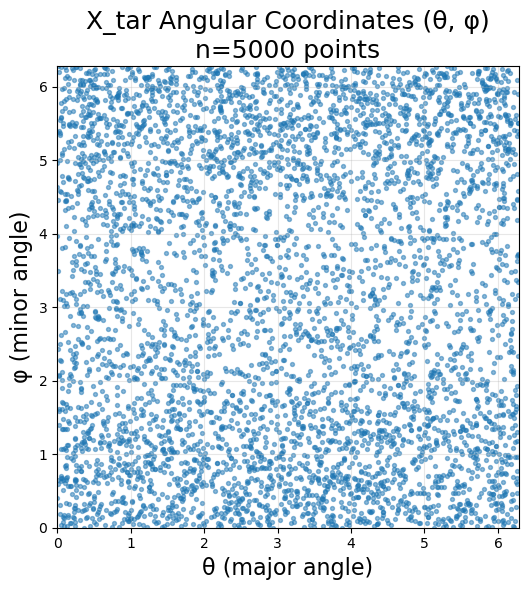


[INFO] In angular space, density ∝ (R + r·cos(φ))
[INFO] Outer edge (φ≈0): higher density | Inner edge (φ≈π): lower density


In [7]:
# Visualize X_tar uniform distribution on torus
import plotly.graph_objects as go
import os

# ============ Plot 1: Interactive 3D scatter (Plotly - can rotate!) ============
# Create torus surface mesh for reference
theta_surf = np.linspace(0, 2 * np.pi, 50)
phi_surf = np.linspace(0, 2 * np.pi, 30)
THETA_S, PHI_S = np.meshgrid(theta_surf, phi_surf)
X_surf = (R + r * np.cos(PHI_S)) * np.cos(THETA_S)
Y_surf = (R + r * np.cos(PHI_S)) * np.sin(THETA_S)
Z_surf = r * np.sin(PHI_S)

fig_3d = go.Figure()

# Add torus surface (semi-transparent)
fig_3d.add_trace(go.Surface(
    x=X_surf, y=Y_surf, z=Z_surf,
    opacity=0.3,
    colorscale='Viridis',
    showscale=False,
    name='Torus Surface'
))

# Add X_tar scatter points
fig_3d.add_trace(go.Scatter3d(
    x=X_tar[:, 0], y=X_tar[:, 1], z=X_tar[:, 2],
    mode='markers',
    marker=dict(size=3, color='blue', opacity=0.7),
    name=f'X_tar (n={n})'
))

# Build title with proper text and math separation
title_text = f'X_tar: Uniform Distribution on Torus 𝕋² (n={n}) | R={R}, r={r}'
fig_3d.update_layout(
    title=dict(
        text=title_text,
        font=dict(size=16)
    ),
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    width=800,
    height=600
)

# Save interactive HTML file (with MathJax enabled for LaTeX rendering)
os.makedirs('figures', exist_ok=True)
html_path = 'figures/X_tar_torus_interactive.html'
fig_3d.write_html(html_path, include_mathjax='cdn')
print(f"[SAVED] Interactive 3D plot saved to: {html_path}")
print(f"        Open this file in a browser to rotate/zoom the plot!")

# Display in notebook (with fallback)
try:
    fig_3d.show(config={'mathjax': 'cdn'})
except Exception as e:
    print(f"[INFO] Cannot display interactive plot in notebook: {e}")
    print(f"[INFO] Please open the HTML file in browser: {html_path}")

# ============ Plot 2: Angular coordinates (θ, φ) - Matplotlib ============
fig2, ax2 = plt.subplots(figsize=(7, 6))
ax2.scatter(theta_tar, phi_tar, s=8, c='C0', alpha=0.5)
ax2.set_xlabel('θ (major angle)', fontsize=16)
ax2.set_ylabel('φ (minor angle)', fontsize=16)
ax2.set_xlim(0, 2*np.pi)
ax2.set_ylim(0, 2*np.pi)
ax2.set_aspect('equal')
ax2.set_title(f'X_tar Angular Coordinates (θ, φ)\nn={n} points', fontsize=18)
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Note: In (θ, φ) space, uniform on torus means MORE points at φ≈0 (outer edge)
# and FEWER points at φ≈π (inner edge), due to the (R + r*cos(φ)) factor
print(f"\n[INFO] In angular space, density ∝ (R + r·cos(φ))")
print(f"[INFO] Outer edge (φ≈0): higher density | Inner edge (φ≈π): lower density")

## 6. Generate X_tar_next via Exact Torus SDE

**Itô SDE for Brownian motion on torus:**
$$
d\theta = \underbrace{\frac{\sin\phi}{r(R + r\cos\phi)^2}}_{\text{Itô correction}} dt + \frac{\sqrt{2}}{R + r\cos\phi} dW_t^1
$$
$$
d\phi = \frac{\sqrt{2}}{r} dW_t^2
$$

Key points:
- The drift term in $\theta$ is the **Itô-Stratonovich correction** (Wong-Zakai correction)
- This correction arises because the diffusion coefficient depends on $\phi$
- The $\phi$ equation has constant diffusion coefficient, so no correction needed

In [8]:
# Time step for SDE integration
dt_edmd = 0.05

# Current angular coordinates
theta_curr = theta_tar.copy()
phi_curr = phi_tar.copy()

# Metric factors
g_theta = R + r * np.cos(phi_curr)  # sqrt(g_θθ) = R + r*cos(φ)
g_phi = r  # sqrt(g_φφ) = r (constant)

# ---------- Itô SDE Integration ----------

# 1. Compute Itô correction term for theta equation
#    Correction = (1/2) * d(σ_θ)/dφ * σ_φ²
#    where σ_θ = 1/(R + r*cos(φ)), σ_φ = 1/r
#    d(σ_θ)/dφ = r*sin(φ) / (R + r*cos(φ))²
#    Correction = sin(φ) / [r * (R + r*cos(φ))²]
ito_correction_theta = np.sin(phi_curr) / (r * g_theta**2)

# 2. Diffusion coefficients (in angular coordinates)
sigma_theta = np.sqrt(2) / g_theta  # Diffusion coefficient for θ
sigma_phi = np.sqrt(2) / g_phi      # Diffusion coefficient for φ (constant)

# 3. Generate Brownian increments
dW1 = np.random.normal(0, np.sqrt(dt_edmd), n)  # For θ
dW2 = np.random.normal(0, np.sqrt(dt_edmd), n)  # For φ

# 4. Euler-Maruyama update (Itô form)
theta_next = theta_curr + ito_correction_theta * dt_edmd + sigma_theta * dW1
phi_next = phi_curr + sigma_phi * dW2

# 5. Wrap angles to [0, 2π) - torus is periodic
theta_next = np.mod(theta_next, 2 * np.pi)
phi_next = np.mod(phi_next, 2 * np.pi)

# 6. Convert back to Cartesian coordinates
X_tar_next = angles_to_cartesian(theta_next, phi_next, R, r)

print(f"[SDE] Itô correction magnitude: mean={np.mean(np.abs(ito_correction_theta)):.4f}, max={np.max(np.abs(ito_correction_theta)):.4f}")
print(f"[SDE] Time step dt = {dt_edmd}")
print(f"[SDE] X_tar_next generated via exact torus SDE")

[SDE] Itô correction magnitude: mean=0.2071, max=0.4338
[SDE] Time step dt = 0.05
[SDE] X_tar_next generated via exact torus SDE


## 7. Visualize Time Evolution Pair (X_tar vs X_tar_next)

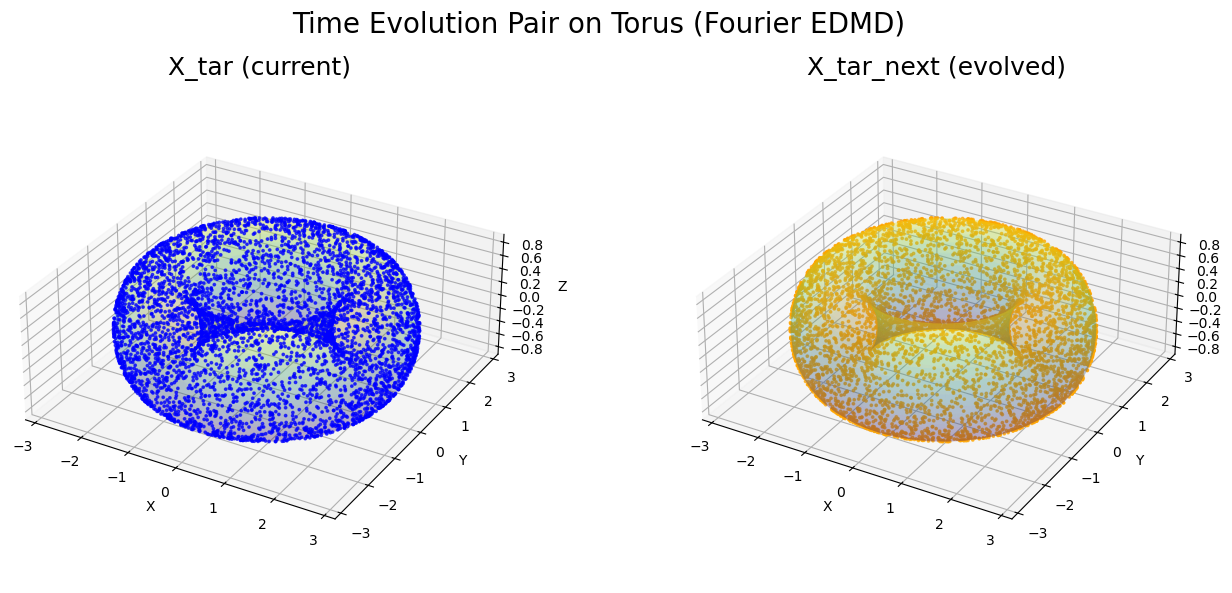

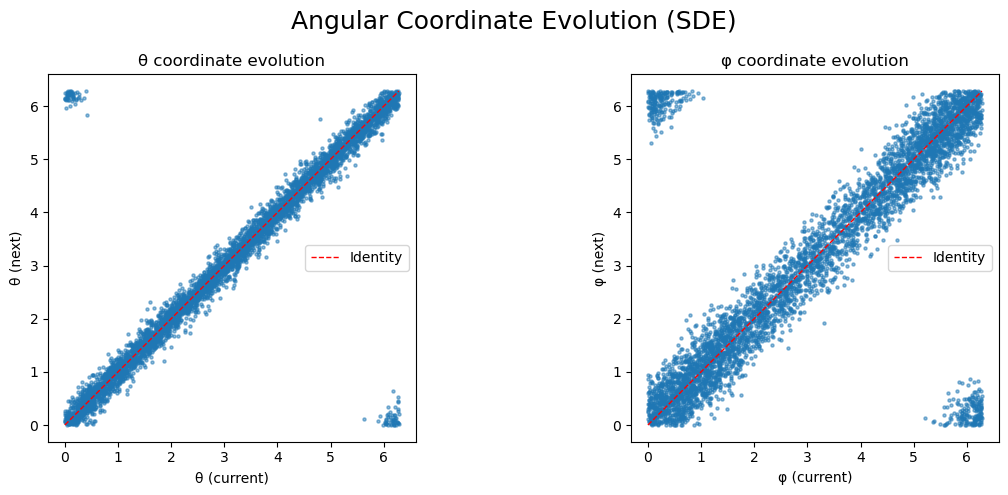

In [9]:
fig = plt.figure(figsize=(14, 6))

# Create torus surface mesh for reference (same as Cell 8)
theta_surf = np.linspace(0, 2 * np.pi, 50)
phi_surf = np.linspace(0, 2 * np.pi, 30)
THETA_S, PHI_S = np.meshgrid(theta_surf, phi_surf)
X_surf = (R + r * np.cos(PHI_S)) * np.cos(THETA_S)
Y_surf = (R + r * np.cos(PHI_S)) * np.sin(THETA_S)
Z_surf = r * np.sin(PHI_S)

# Plot X_tar
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
ax1.scatter(X_tar[:, 0], X_tar[:, 1], X_tar[:, 2], s=3, c='blue', alpha=0.7)
ax1.set_title('X_tar (current)', fontsize=18)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_box_aspect([1, 1, 0.4])

# Plot X_tar_next
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
ax2.scatter(X_tar_next[:, 0], X_tar_next[:, 1], X_tar_next[:, 2], s=3, c='orange', alpha=0.7)
ax2.set_title('X_tar_next (evolved)', fontsize=18)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_box_aspect([1, 1, 0.4])

plt.suptitle(f'Time Evolution Pair on Torus (Fourier EDMD)', fontsize=20)
plt.tight_layout()
plt.show()

# Also show angular coordinate evolution
fig2, axes = plt.subplots(1, 2, figsize=(12, 5))

# θ evolution
axes[0].scatter(theta_tar, theta_next, s=5, alpha=0.5)
axes[0].plot([0, 2*np.pi], [0, 2*np.pi], 'r--', lw=1, label='Identity')
axes[0].set_xlabel('θ (current)')
axes[0].set_ylabel('θ (next)')
axes[0].set_title('θ coordinate evolution')
axes[0].legend()
axes[0].set_aspect('equal')

# φ evolution
axes[1].scatter(phi_tar, phi_next, s=5, alpha=0.5)
axes[1].plot([0, 2*np.pi], [0, 2*np.pi], 'r--', lw=1, label='Identity')
axes[1].set_xlabel('φ (current)')
axes[1].set_ylabel('φ (next)')
axes[1].set_title('φ coordinate evolution')
axes[1].legend()
axes[1].set_aspect('equal')

plt.suptitle('Angular Coordinate Evolution (SDE)', fontsize=18)
plt.tight_layout()
plt.show()

## 8. Define Fourier Basis Functions

For a torus $T^2$ parametrized by $(\theta, \phi) \in [0, 2\pi)^2$, the natural orthonormal basis functions are:
$$
\psi_{k_\theta, k_\phi}(\theta, \phi) = \frac{1}{2\pi} e^{i(k_\theta \theta + k_\phi \phi)}, \quad (k_\theta, k_\phi) \in \mathbb{Z}^2
$$

For numerical stability, we use real-valued basis functions:
- $\cos(k_\theta \theta + k_\phi \phi)$ and $\sin(k_\theta \theta + k_\phi \phi)$

The number of basis functions is chosen based on the Fourier mode cutoff $N$:
- Modes: $(k_\theta, k_\phi) \in \{-N, \ldots, N\}^2$
- Total: $(2N+1)^2$ complex modes, or approximately $2(2N+1)^2$ real modes

In [10]:
def build_fourier_basis_indices(N_modes):
    """
    Build the list of (k_theta, k_phi) indices for Fourier basis.
    
    Returns:
        k_theta_list: list of theta wave numbers
        k_phi_list: list of phi wave numbers
        
    The total number of basis functions is (2*N_modes + 1)^2 for complex,
    or roughly 2x that for real (cos/sin) representation.
    """
    k_theta_list = []
    k_phi_list = []
    
    for k_theta in range(-N_modes, N_modes + 1):
        for k_phi in range(-N_modes, N_modes + 1):
            k_theta_list.append(k_theta)
            k_phi_list.append(k_phi)
    
    return np.array(k_theta_list), np.array(k_phi_list)


def evaluate_fourier_basis(theta, phi, k_theta_arr, k_phi_arr):
    """
    Evaluate Fourier basis functions at given angular coordinates.
    
    Parameters:
        theta: array of shape (n,) - major angle
        phi: array of shape (n,) - minor angle
        k_theta_arr: array of wave numbers for theta
        k_phi_arr: array of wave numbers for phi
        
    Returns:
        Psi: array of shape (n, n_basis) - real-valued basis functions
             Using cos and sin for real representation
    """
    n_pts = len(theta)
    n_modes = len(k_theta_arr)
    
    # Compute phases: k_theta * theta + k_phi * phi for all points and modes
    # theta: (n,), k_theta: (n_modes,)
    phases = np.outer(theta, k_theta_arr) + np.outer(phi, k_phi_arr)  # (n, n_modes)
    
    # Real-valued representation using cos and sin
    # For mode (0, 0), only cos is needed (constant = 1)
    # For other modes, we need both cos and sin
    
    # Simple approach: use complex exponential and take real/imag parts
    # exp(i * phase) = cos(phase) + i * sin(phase)
    cos_basis = np.cos(phases)  # (n, n_modes)
    sin_basis = np.sin(phases)  # (n, n_modes)
    
    # Combine into single basis matrix
    # Note: for mode (0,0), sin(0) = 0, so we can include it but it adds no information
    # For efficiency, concatenate cos and sin (excluding the constant mode's sin)
    Psi = np.concatenate([cos_basis, sin_basis[:, 1:]], axis=1)  # (n, 2*n_modes - 1)
    
    return Psi


def evaluate_fourier_basis_gradient(theta, phi, k_theta_arr, k_phi_arr, R, r):
    """
    Evaluate gradients of Fourier basis functions in R^3.
    
    Returns:
        dPsi_dX: array of shape (n, n_basis, 3) - gradient of each basis function
                 with respect to Cartesian coordinates (x, y, z)
    
    Chain rule: dψ/dx = (dψ/dθ)(dθ/dx) + (dψ/dφ)(dφ/dx)
    
    For ψ = cos(k_θ θ + k_φ φ):
        dψ/dθ = -k_θ sin(k_θ θ + k_φ φ)
        dψ/dφ = -k_φ sin(k_θ θ + k_φ φ)
        
    For ψ = sin(k_θ θ + k_φ φ):
        dψ/dθ = k_θ cos(k_θ θ + k_φ φ)
        dψ/dφ = k_φ cos(k_θ θ + k_φ φ)
        
    Jacobian (angle to Cartesian):
        dθ/dx = -sin(θ) / (R + r cos(φ))
        dθ/dy = cos(θ) / (R + r cos(φ))
        dθ/dz = 0
        
        dφ/dx = -cos(θ) sin(φ) / r
        dφ/dy = -sin(θ) sin(φ) / r  
        dφ/dz = cos(φ) / r
    """
    n_pts = len(theta)
    n_modes = len(k_theta_arr)
    
    # Phases
    phases = np.outer(theta, k_theta_arr) + np.outer(phi, k_phi_arr)  # (n, n_modes)
    cos_phases = np.cos(phases)
    sin_phases = np.sin(phases)
    
    # Jacobian elements: d(θ,φ)/d(x,y,z)
    g_theta = R + r * np.cos(phi)  # (n,)
    
    dtheta_dx = -np.sin(theta) / g_theta  # (n,)
    dtheta_dy = np.cos(theta) / g_theta
    dtheta_dz = np.zeros(n_pts)
    
    dphi_dx = -np.cos(theta) * np.sin(phi) / r
    dphi_dy = -np.sin(theta) * np.sin(phi) / r
    dphi_dz = np.cos(phi) / r
    
    # Stack Jacobian: (n, 2, 3) where [:, 0, :] is d(theta)/d(x,y,z), [:, 1, :] is d(phi)/d(x,y,z)
    J = np.zeros((n_pts, 2, 3))
    J[:, 0, 0] = dtheta_dx
    J[:, 0, 1] = dtheta_dy
    J[:, 0, 2] = dtheta_dz
    J[:, 1, 0] = dphi_dx
    J[:, 1, 1] = dphi_dy
    J[:, 1, 2] = dphi_dz
    
    # Gradients for cos basis: dψ/d(x,y,z) = -k_theta * sin(phase) * dtheta/d(xyz) - k_phi * sin(phase) * dphi/d(xyz)
    # Shape: (n, n_modes, 3)
    dcos_dtheta = -k_theta_arr[None, :] * sin_phases  # (n, n_modes)
    dcos_dphi = -k_phi_arr[None, :] * sin_phases  # (n, n_modes)
    
    dcos_dX = np.zeros((n_pts, n_modes, 3))
    for dim in range(3):
        dcos_dX[:, :, dim] = dcos_dtheta * J[:, 0, dim][:, None] + dcos_dphi * J[:, 1, dim][:, None]
    
    # Gradients for sin basis (excluding first mode which is sin(0)=0)
    dsin_dtheta = k_theta_arr[None, 1:] * cos_phases[:, 1:]  # (n, n_modes-1)
    dsin_dphi = k_phi_arr[None, 1:] * cos_phases[:, 1:]  # (n, n_modes-1)
    
    dsin_dX = np.zeros((n_pts, n_modes - 1, 3))
    for dim in range(3):
        dsin_dX[:, :, dim] = dsin_dtheta * J[:, 0, dim][:, None] + dsin_dphi * J[:, 1, dim][:, None]
    
    # Combine gradients
    dPsi_dX = np.concatenate([dcos_dX, dsin_dX], axis=1)  # (n, 2*n_modes - 1, 3)
    
    return dPsi_dX


# Build Fourier basis indices
k_theta_arr, k_phi_arr = build_fourier_basis_indices(N_FOURIER_MODES)
n_total_modes = len(k_theta_arr)
n_basis = 2 * n_total_modes - 1  # cos + sin (excluding sin(0))

print(f"[FOURIER] Number of (k_theta, k_phi) pairs: {n_total_modes}")
print(f"[FOURIER] Total real-valued basis functions: {n_basis}")
print(f"[FOURIER] Wave number range: k ∈ [{-N_FOURIER_MODES}, {N_FOURIER_MODES}]")

[FOURIER] Number of (k_theta, k_phi) pairs: 121
[FOURIER] Total real-valued basis functions: 241
[FOURIER] Wave number range: k ∈ [-5, 5]


## 9. Compute Fourier Basis EDMD Matrices

**Fourier EDMD** approximates the Koopman operator in the space spanned by Fourier basis functions:

1. Evaluate basis functions $\Psi(X_t)$ and $\Psi(X_{t+dt})$ at data points
2. Solve least squares: $K \approx \Psi(X_{t+dt}) \Psi(X_t)^\dagger$
3. Eigendecomposition of $K$ gives Koopman eigenvalues and eigenfunctions

In [11]:
# ============ Evaluate Fourier basis at data points ============
# Need angular coordinates
theta_tar_angles, phi_tar_angles = cartesian_to_angles(X_tar, R, r)
theta_next_angles, phi_next_angles = cartesian_to_angles(X_tar_next, R, r)

# Evaluate basis functions
Psi_X = evaluate_fourier_basis(theta_tar_angles, phi_tar_angles, k_theta_arr, k_phi_arr)  # (n, n_basis)
Psi_Y = evaluate_fourier_basis(theta_next_angles, phi_next_angles, k_theta_arr, k_phi_arr)  # (n, n_basis)

print(f"[FOURIER EDMD] Psi_X shape: {Psi_X.shape}")
print(f"[FOURIER EDMD] Psi_Y shape: {Psi_Y.shape}")

# ============ Compute EDMD matrices ============
# G = (1/n) Psi_X^T @ Psi_X  (Gram matrix in feature space)
# A = (1/n) Psi_X^T @ Psi_Y  (Cross-covariance matrix)
# Koopman approximation: K = G^{-1} A

G_matrix = (1.0 / n) * (Psi_X.T @ Psi_X)  # (n_basis, n_basis)
A_matrix = (1.0 / n) * (Psi_X.T @ Psi_Y)  # (n_basis, n_basis)

# Regularized inversion
gamma_ridge = 1e-6
G_reg = G_matrix + gamma_ridge * np.eye(n_basis)
G_inv = np.linalg.inv(G_reg)
K_edmd = G_inv @ A_matrix  # Koopman matrix in Fourier basis

print(f"[FOURIER EDMD] G matrix condition number: {np.linalg.cond(G_matrix):.2e}")
print(f"[FOURIER EDMD] K_edmd shape: {K_edmd.shape}")

# Store for gradient computations (keep bandwidth for compatibility)
sq_tar = np.sum(X_tar ** 2, axis=1)
H = sq_tar[:, None] + sq_tar[None, :] - 2 * (X_tar @ X_tar.T)
H = np.maximum(H, 0)
epsilon = 0.5 * np.median(H) / (np.log(n + 1) + 1e-12)

_t = _print_phase("Fourier EDMD: Compute K_edmd", _t)

[FOURIER EDMD] Psi_X shape: (5000, 241)
[FOURIER EDMD] Psi_Y shape: (5000, 241)
[FOURIER EDMD] G matrix condition number: 9.62e+32
[FOURIER EDMD] K_edmd shape: (241, 241)
[TIMER] Fourier EDMD: Compute K_edmd: 1.634s


## 10. Eigendecomposition of Koopman Matrix

Compute eigenvalues and eigenvectors of the Koopman matrix $K_{EDMD}$.
- **Retain only top N_MODES_RETAIN modes** (excluding λ≈1 trivial mode and small eigenvalues)

In [12]:
# ============ Eigendecomposition of Koopman matrix ============
# K_edmd may not be symmetric, use general eigendecomposition
evals_K, evecs_K = np.linalg.eig(K_edmd)

# Sort by magnitude of eigenvalues (descending)
sort_idx = np.argsort(np.abs(evals_K))[::-1]
evals_K = evals_K[sort_idx]
evecs_K = evecs_K[:, sort_idx]

# Take real parts (for real-valued Koopman eigenfunctions)
evals_K = np.real(evals_K)
evecs_K = np.real(evecs_K)

print(f"[KOOPMAN] Eigenvalue shape: {evals_K.shape}")
print(f"[KOOPMAN] First 10 eigenvalues (sorted by magnitude):")
for i in range(min(10, len(evals_K))):
    print(f"  λ[{i}] = {evals_K[i]:.8f}")

# ============ Filter eigenvalues ============
# 1. Remove eigenvalues close to 1 (trivial/constant mode)
# 2. Remove eigenvalues below threshold (numerical noise)

tol_trivial = 0.01  # Eigenvalues within 1 ± tol are considered trivial
tol_small = 1e-6    # Eigenvalues below this are too small

mask_not_trivial = np.abs(evals_K - 1.0) > tol_trivial
mask_not_small = np.abs(evals_K) > tol_small
mask_valid = mask_not_trivial & mask_not_small

# Count filtered modes
n_trivial = np.sum(~mask_not_trivial)
n_small = np.sum(~mask_not_small)
n_valid = np.sum(mask_valid)

print(f"\n[FILTER] Trivial modes (|λ-1| < {tol_trivial}): {n_trivial}")
print(f"[FILTER] Small modes (|λ| < {tol_small:.0e}): {n_small}")
print(f"[FILTER] Valid modes remaining: {n_valid}")

# Retain only top N_MODES_RETAIN valid modes
valid_indices = np.where(mask_valid)[0]
n_retain_koopman = min(N_MODES_RETAIN, len(valid_indices))
retain_indices_koopman = valid_indices[:n_retain_koopman]

evals_K_retained = evals_K[retain_indices_koopman]
evecs_K_retained = evecs_K[:, retain_indices_koopman]

print(f"[KOOPMAN] Retaining top {n_retain_koopman} Koopman modes")
print(f"[KOOPMAN] Retained eigenvalue range: [{evals_K_retained.min():.6f}, {evals_K_retained.max():.6f}]")

_t = _print_phase("Koopman eigendecomposition", _t)

[KOOPMAN] Eigenvalue shape: (241,)
[KOOPMAN] First 10 eigenvalues (sorted by magnitude):
  λ[0] = 0.99999890
  λ[1] = 0.98793019
  λ[2] = 0.98059826
  λ[3] = 0.95228843
  λ[4] = 0.95006940
  λ[5] = 0.92579069
  λ[6] = 0.92306815
  λ[7] = 0.92306815
  λ[8] = 0.91719100
  λ[9] = 0.91719100

[FILTER] Trivial modes (|λ-1| < 0.01): 1
[FILTER] Small modes (|λ| < 1e-06): 120
[FILTER] Valid modes remaining: 120
[KOOPMAN] Retaining top 50 Koopman modes
[KOOPMAN] Retained eigenvalue range: [0.552177, 0.987930]
[TIMER] Koopman eigendecomposition: 0.040s


## 11. Diffusion Maps (DM) Spectral Decomposition

Compute diffusion maps kernel from Fourier basis:
- $P = \Psi_X \Psi_X^T$ is the Gram matrix in data space
- Normalize to get random-walk Laplacian
- **Retain only top N_MODES_RETAIN modes** (excluding λ≈1 and small eigenvalues)

In [13]:
# ============ Build DM-style kernel from Fourier basis ============
# For Fourier basis, we need to construct a proper positive semi-definite kernel
# 
# Option 1: Use |K_fourier| or K_fourier^2 to ensure positivity
# Option 2: Use RBF-like kernel with Fourier features: K = exp(-||Psi(x) - Psi(y)||^2 / 2sigma^2)
# Option 3: Use the absolute value of the inner product

# Compute Fourier inner product kernel
K_fourier_raw = Psi_X @ Psi_X.T  # (n, n) may have negative values

# Shift to make all values positive (simple approach)
K_min = K_fourier_raw.min()
if K_min < 0:
    K_fourier = K_fourier_raw - K_min + 1e-10  # Shift to positive
else:
    K_fourier = K_fourier_raw + 1e-10

print(f"[DM] Raw Fourier kernel range: [{K_fourier_raw.min():.4e}, {K_fourier_raw.max():.4e}]")
print(f"[DM] Shifted kernel range: [{K_fourier.min():.4e}, {K_fourier.max():.4e}]")

# Normalize for density (now safe since K_fourier > 0)
row_sums = np.sum(K_fourier, axis=1)
p_x = np.sqrt(np.maximum(row_sums, 1e-12))  # Ensure positive
p_y = p_x.copy()
K_fourier_norm = K_fourier / p_x[:, None] / p_y[None, :]

# Random-walk normalization
D_y = np.sum(K_fourier_norm, axis=0)
D_y = np.maximum(D_y, 1e-12)  # Avoid division by zero
rw_kernel = 0.5 * (K_fourier_norm / D_y + K_fourier_norm / D_y[:, None])

# Clean up any remaining NaN/Inf
rw_kernel = np.nan_to_num(rw_kernel, nan=0.0, posinf=0.0, neginf=0.0)

print(f"[DM] Normalized kernel shape: {rw_kernel.shape}")
print(f"[DM] Kernel value range: [{rw_kernel.min():.4e}, {rw_kernel.max():.4e}]")
print(f"[DM] Has NaN: {np.any(np.isnan(rw_kernel))}, Has Inf: {np.any(np.isinf(rw_kernel))}")

# Store for gradient computations
p_tar = np.sum(K_fourier, axis=0)
p_tar = np.maximum(p_tar, 1e-12)
D = np.sum(K_fourier / np.sqrt(p_tar)[:, None] / np.sqrt(p_tar)[None, :], axis=1)

[DM] Raw Fourier kernel range: [-2.7252e+01, 1.2100e+02]
[DM] Shifted kernel range: [1.0000e-10, 1.4825e+02]
[DM] Normalized kernel shape: (5000, 5000)
[DM] Kernel value range: [7.1138e-16, 1.0837e-03]
[DM] Has NaN: False, Has Inf: False


## 12. DM Spectral Decomposition

Eigendecomposition of the normalized random-walk kernel.
- **Retain only top N_MODES_RETAIN modes** (excluding λ≈1 trivial mode)

In [14]:
# ============ DM Eigendecomposition ============
# rw_kernel is symmetric, use eigh for efficiency
evals_rw, evecs_rw = eigh(rw_kernel)

# Reverse to get descending order
phi_dm = evecs_rw[:, ::-1]  # (n, n) eigenvectors
s_dm = evals_rw[::-1]       # (n,) eigenvalues

print(f"[DM] Total eigenvalues: {len(s_dm)}")
print(f"[DM] First 10 eigenvalues:")
for i in range(min(10, len(s_dm))):
    print(f"  λ_DM[{i}] = {s_dm[i]:.8f}")

# ============ Filter DM eigenvalues ============
# 1. Remove first eigenvalue (λ ≈ 1, constant mode)
# 2. Remove eigenvalues below threshold

tol_dm_trivial = 0.01
tol_dm_small = 1e-6

mask_dm_not_trivial = np.abs(s_dm - 1.0) > tol_dm_trivial
mask_dm_not_small = np.abs(s_dm) > tol_dm_small
mask_dm_valid = mask_dm_not_trivial & mask_dm_not_small

n_dm_trivial = np.sum(~mask_dm_not_trivial)
n_dm_small = np.sum(~mask_dm_not_small)
n_dm_valid = np.sum(mask_dm_valid)

print(f"\n[DM FILTER] Trivial modes (|λ-1| < {tol_dm_trivial}): {n_dm_trivial}")
print(f"[DM FILTER] Small modes (|λ| < {tol_dm_small:.0e}): {n_dm_small}")
print(f"[DM FILTER] Valid modes remaining: {n_dm_valid}")

# Retain only top N_MODES_RETAIN valid DM modes
valid_dm_indices = np.where(mask_dm_valid)[0]
n_retain_dm = min(N_MODES_RETAIN, len(valid_dm_indices))
retain_dm_indices = valid_dm_indices[:n_retain_dm]

lambda_ns = s_dm[retain_dm_indices]  # DM eigenvalues (retained)
phi = phi_dm[:, retain_dm_indices]   # DM eigenvectors (retained)

print(f"[DM] Retaining top {n_retain_dm} DM modes")
print(f"[DM] Retained eigenvalue range: [{lambda_ns.min():.6f}, {lambda_ns.max():.6f}]")

# For compatibility with downstream code
above_tol = n_retain_dm

_t = _print_phase("DM eigendecomposition with filtering", _t)

[DM] Total eigenvalues: 5000
[DM] First 10 eigenvalues:
  λ_DM[0] = 1.00000679
  λ_DM[1] = 0.05956195
  λ_DM[2] = 0.05580426
  λ_DM[3] = 0.05556794
  λ_DM[4] = 0.05469934
  λ_DM[5] = 0.05445084
  λ_DM[6] = 0.05268597
  λ_DM[7] = 0.05196834
  λ_DM[8] = 0.05095131
  λ_DM[9] = 0.05073281

[DM FILTER] Trivial modes (|λ-1| < 0.01): 1
[DM FILTER] Small modes (|λ| < 1e-06): 4879
[DM FILTER] Valid modes remaining: 120
[DM] Retaining top 50 DM modes
[DM] Retained eigenvalue range: [0.038356, 0.059562]
[TIMER] DM eigendecomposition with filtering: 5.620s


## 13. Spectral Analysis (Koopman and DM)


[SPECTRAL ANALYSIS SUMMARY]

--- Koopman Spectrum (Fourier EDMD) ---
Total basis functions: 241
Retained Koopman modes: 50
Koopman eigenvalue range: [0.552177, 0.987930]

--- Diffusion Map Spectrum ---
Total DM eigenvalues: 5000
Retained DM modes: 50
DM eigenvalue range: [0.038356, 0.059562]



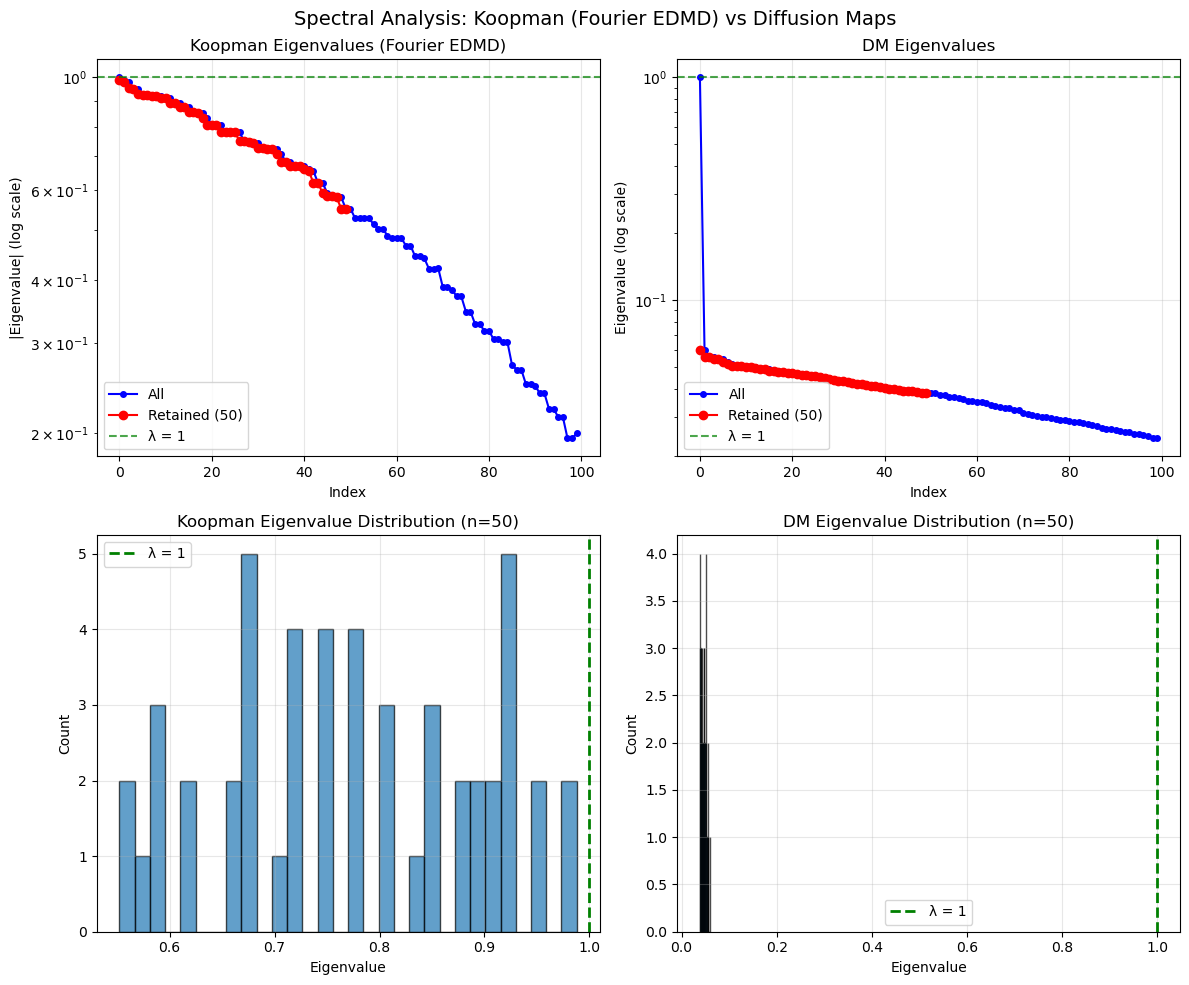

In [15]:
print("\n" + "=" * 60)
print("[SPECTRAL ANALYSIS SUMMARY]")
print("=" * 60)

print(f"\n--- Koopman Spectrum (Fourier EDMD) ---")
print(f"Total basis functions: {n_basis}")
print(f"Retained Koopman modes: {n_retain_koopman}")
print(f"Koopman eigenvalue range: [{evals_K_retained.min():.6f}, {evals_K_retained.max():.6f}]")

print(f"\n--- Diffusion Map Spectrum ---")
print(f"Total DM eigenvalues: {len(s_dm)}")
print(f"Retained DM modes: {n_retain_dm}")
print(f"DM eigenvalue range: [{lambda_ns.min():.6f}, {lambda_ns.max():.6f}]")

print("=" * 60 + "\n")

# Plot eigenvalue spectra
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Koopman eigenvalues (all)
ax1 = axes[0, 0]
ax1.semilogy(np.abs(evals_K[:100]), 'bo-', markersize=4, label='All')
ax1.semilogy(np.abs(evals_K_retained), 'ro-', markersize=6, label=f'Retained ({n_retain_koopman})')
ax1.axhline(y=1.0, color='g', linestyle='--', alpha=0.7, label='λ = 1')
ax1.set_xlabel('Index')
ax1.set_ylabel('|Eigenvalue| (log scale)')
ax1.set_title('Koopman Eigenvalues (Fourier EDMD)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: DM eigenvalues (all)
ax2 = axes[0, 1]
ax2.semilogy(s_dm[:100], 'bo-', markersize=4, label='All')
ax2.semilogy(lambda_ns, 'ro-', markersize=6, label=f'Retained ({n_retain_dm})')
ax2.axhline(y=1.0, color='g', linestyle='--', alpha=0.7, label='λ = 1')
ax2.set_xlabel('Index')
ax2.set_ylabel('Eigenvalue (log scale)')
ax2.set_title('DM Eigenvalues')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Koopman eigenvalue histogram
ax3 = axes[1, 0]
ax3.hist(evals_K_retained, bins=30, edgecolor='black', alpha=0.7)
ax3.axvline(x=1.0, color='g', linestyle='--', linewidth=2, label='λ = 1')
ax3.set_xlabel('Eigenvalue')
ax3.set_ylabel('Count')
ax3.set_title(f'Koopman Eigenvalue Distribution (n={n_retain_koopman})')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: DM eigenvalue histogram
ax4 = axes[1, 1]
ax4.hist(lambda_ns, bins=30, edgecolor='black', alpha=0.7)
ax4.axvline(x=1.0, color='g', linestyle='--', linewidth=2, label='λ = 1')
ax4.set_xlabel('Eigenvalue')
ax4.set_ylabel('Count')
ax4.set_title(f'DM Eigenvalue Distribution (n={n_retain_dm})')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Spectral Analysis: Koopman (Fourier EDMD) vs Diffusion Maps', fontsize=14)
plt.tight_layout()
plt.show()

## 14. Compute Inverse Weights for Gradient Calculations

Using the retained DM eigenvectors and eigenvalues for KSWGD gradient computation.

In [16]:
# Compute inverse lambda for gradient calculations
# lambda_ = 1 - lambda_ns (Laplacian eigenvalues)
lambda_ = 1.0 - lambda_ns  # These should be positive since lambda_ns < 1

# Regularization for numerical stability
reg = 0.001
inv_lambda = epsilon / (lambda_ + reg)

# Compute inverse kernel matrices using retained eigenvectors
inv_K = phi @ np.diag(inv_lambda) @ phi.T

# For KSWGD: compute combined weight matrix
lambda_ns_inv = epsilon / (lambda_ns + reg)
lambda_ns_s_ns = lambda_ns_inv * inv_lambda * lambda_ns_inv
inv_K_ns_s_ns = phi @ np.diag(lambda_ns_s_ns) @ phi.T

print(f"[WEIGHTS] Number of retained modes: {above_tol}")
print(f"[WEIGHTS] inv_K shape: {inv_K.shape}")
print(f"[WEIGHTS] lambda_ range: [{lambda_.min():.6f}, {lambda_.max():.6f}]")
print(f"[WEIGHTS] inv_lambda range: [{inv_lambda.min():.4e}, {inv_lambda.max():.4e}]")

[WEIGHTS] Number of retained modes: 50
[WEIGHTS] inv_K shape: (5000, 5000)
[WEIGHTS] lambda_ range: [0.940438, 0.961644]
[WEIGHTS] inv_lambda range: [5.6243e-01, 5.7510e-01]


## 15. Particle Initialization

Initialize particles in a **localized region** of the torus to observe diffusion.
We place particles near the "top" of the torus tube (φ ≈ π/2) and at a specific θ location.

In [17]:
# KSWGD parameters
num_iter = 2000
h = 0.001  # Step size
m_init = 500  # Initial number of particles to generate

# Initialize particles in a local region of the torus
# Location: near θ ≈ 0 and φ ≈ π/2 (top of the tube, front of the torus)
theta_init_center = 0.0
phi_init_center = np.pi / 2  # Top of the tube

# Generate particles with small spread around the center
theta_spread = 0.3  # Spread in θ direction
phi_spread = 0.3    # Spread in φ direction

theta_init = theta_init_center + np.random.uniform(-theta_spread, theta_spread, m_init)
phi_init = phi_init_center + np.random.uniform(-phi_spread, phi_spread, m_init)

# Wrap to [0, 2π)
theta_init = np.mod(theta_init, 2 * np.pi)
phi_init = np.mod(phi_init, 2 * np.pi)

# Convert to Cartesian
x_init = angles_to_cartesian(theta_init, phi_init, R, r)
m = x_init.shape[0]

print(f"[INFO] Initialized {m} particles in local region:")
print(f"       θ ∈ [{theta_init.min():.2f}, {theta_init.max():.2f}] (center: {theta_init_center:.2f})")
print(f"       φ ∈ [{phi_init.min():.2f}, {phi_init.max():.2f}] (center: {phi_init_center:.2f})")

# Initialize trajectory storage
x_t = np.zeros((m, d, num_iter), dtype=np.float64)
x_t[:, :, 0] = x_init

sum_x = np.zeros((m, d))

[INFO] Initialized 500 particles in local region:
       θ ∈ [0.00, 6.28] (center: 0.00)
       φ ∈ [1.27, 1.87] (center: 1.57)


## 16. KSWGD Iteration Loop (Fourier Basis)

**Fourier Basis EDMD**: The Koopman operator and DM are both computed using Fourier basis.

The gradient computation uses the Fourier basis functions and their derivatives:
$$
\nabla_x \sum_j \psi_k(x_j) = \sum_j \nabla_x \psi_k(x_j)
$$

In [18]:
loop_start = time.time()
total_loop = num_iter - 1

# Precompute weight matrix in DM eigenspace
W_matrix = phi @ np.diag(lambda_ns_s_ns) @ phi.T  # (n, n)

# ============ Pure Fourier Basis KSWGD (NO kernel functions) ============
# Gradient of KSWGD objective uses Fourier basis directly:
# 
# The key quantity is: ∇_x [ Ψ(x)^T @ W @ Ψ(X_tar)^T @ Ψ(X_tar) @ W @ Ψ(x) ]
# 
# Simplified approach using DM eigenvectors:
# - phi_dm[:, k] gives the k-th eigenfunction evaluated at X_tar points
# - To evaluate at new point x, we use Fourier interpolation

def fourier_kswgd_gradient(x_particles, X_tar, theta_tar, phi_tar, 
                            k_theta_arr, k_phi_arr, dm_eigenvecs, dm_weights, R, r):
    """
    Compute KSWGD gradient using Fourier basis (no kernel).
    
    Parameters:
        x_particles: (m, 3) current particle positions in R^3
        X_tar: (n, 3) target data points
        theta_tar, phi_tar: (n,) angular coordinates of target
        k_theta_arr, k_phi_arr: Fourier wave numbers
        dm_eigenvecs: (n, n_retain) DM eigenvectors at target points
        dm_weights: (n_retain,) weight for each mode (lambda_ns_s_ns)
        R, r: torus parameters
        
    Returns:
        grad: (m, 3) gradient for each particle
    """
    m_pts = x_particles.shape[0]
    n_pts = X_tar.shape[0]
    n_modes = len(k_theta_arr)
    n_retain = dm_eigenvecs.shape[1]
    
    # Convert particles to angular coordinates
    theta_p, phi_p = cartesian_to_angles(x_particles, R, r)
    
    # Evaluate Fourier basis at particles: Psi_p (m, n_basis)
    Psi_p = evaluate_fourier_basis(theta_p, phi_p, k_theta_arr, k_phi_arr)
    
    # Evaluate Fourier basis gradient at particles: dPsi_p (m, n_basis, 3)
    dPsi_p = evaluate_fourier_basis_gradient(theta_p, phi_p, k_theta_arr, k_phi_arr, R, r)
    
    # Fourier basis at target: Psi_X (n, n_basis) - already computed
    # Psi_X is global variable
    
    # ============ Compute gradient ============
    # The KSWGD gradient (simplified) involves:
    # grad_x = sum over j in target: W(x, x_j) * ∇_x K(x, x_j) / sum(W)
    #
    # Using Fourier basis: K(x, y) ≈ Psi(x)^T @ Psi(y)
    # ∇_x K(x, y) = dPsi(x)^T @ Psi(y)  (for each spatial dimension)
    
    # Fourier kernel values: K_fourier_px = Psi_p @ Psi_X^T  shape (m, n)
    K_fourier_px = Psi_p @ Psi_X.T
    
    # Apply DM weighting: weighted_K = K_fourier_px @ W_matrix (m, n)
    # W_matrix = phi @ diag(weights) @ phi^T
    weighted_K = K_fourier_px @ W_matrix
    
    # Gradient of Fourier kernel: dK/dx = dPsi_p @ Psi_X^T  shape (m, n, 3)
    dK_fourier = np.zeros((m_pts, n_pts, 3))
    for dim in range(3):
        dK_fourier[:, :, dim] = dPsi_p[:, :, dim] @ Psi_X.T
    
    # Weighted gradient: sum over target points
    # grad[:, dim] = sum_j ( weighted_K[:, j] * dK[:, j, dim] )
    grad = np.zeros((m_pts, 3))
    for dim in range(3):
        # Element-wise multiply and sum over target axis
        grad[:, dim] = np.sum(weighted_K * dK_fourier[:, :, dim], axis=1)
    
    return grad

# CPU iteration loop (pure Fourier, no kernel functions)
for t in range(num_iter - 1):
    # Compute gradient using Fourier basis
    grad = fourier_kswgd_gradient(
        x_t[:, :, t], X_tar, theta_tar_angles, phi_tar_angles,
        k_theta_arr, k_phi_arr, phi, lambda_ns_s_ns, R, r
    )
    
    # Update particles in R³
    x_new = x_t[:, :, t] - (h / m) * grad
    
    # Optionally project back to torus surface
    if USE_PROJECTION:
        x_new_projected = angles_to_cartesian(*cartesian_to_angles(x_new, R, r), R, r)
        x_t[:, :, t + 1] = x_new_projected
    else:
        x_t[:, :, t + 1] = x_new
    
    done = t + 1
    if done == total_loop or (done % max(1, total_loop // 100) == 0):
        _print_progress(done, total_loop, loop_start, prefix="[Fourier-EDMD] ")

print()
_t = _print_phase("Iteration loop total (Fourier basis)", loop_start)

[Fourier-EDMD] [==============================] 100.0% | iter 1999/1999 | elapsed 05:23 | eta 00:00
[TIMER] Iteration loop total (Fourier basis): 323.811s


## 17. Visualize Results (3D)

- **Blue dots**: Target distribution (uniform on torus)
- **Red solid circles**: Initial particle positions (localized)
- **Magenta hollow circles**: Final particle positions (should spread out)

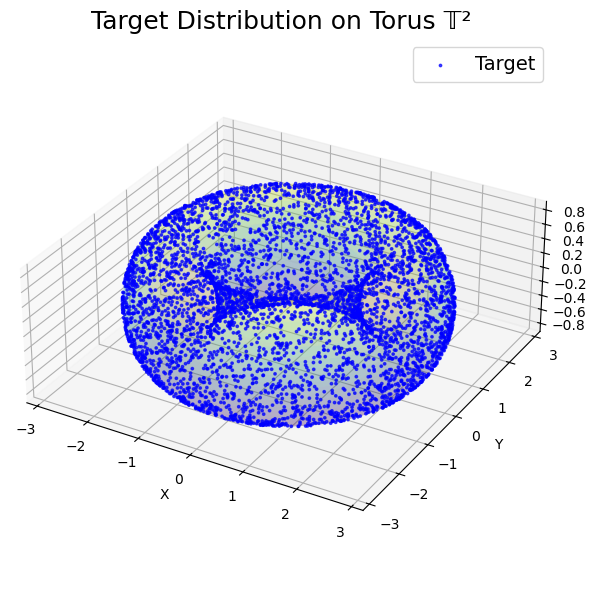

Fourier EDMD: N_modes=5, n=5000, retained modes=50


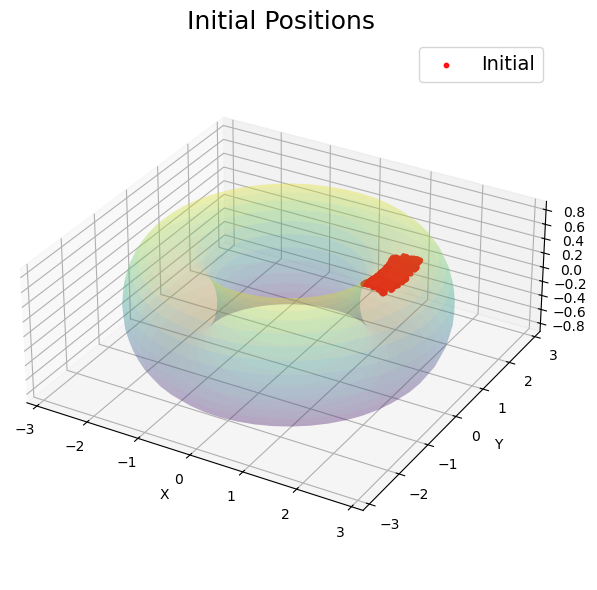

m=500 particles


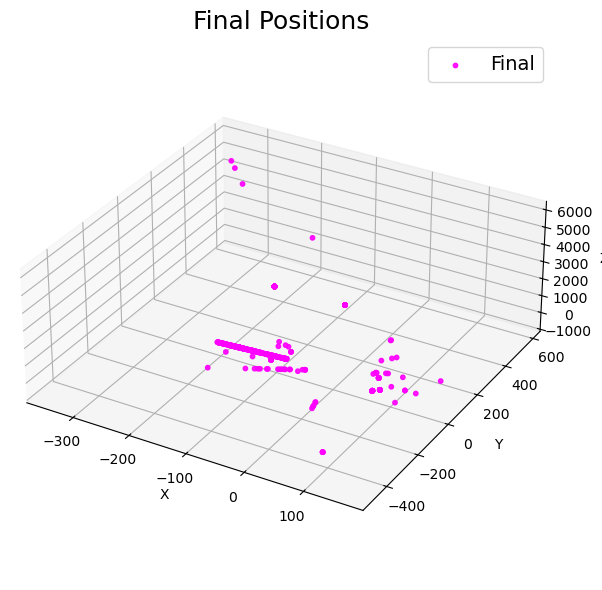

after 2000 iterations


In [19]:
# Create torus surface mesh for reference
theta_surf = np.linspace(0, 2 * np.pi, 50)
phi_surf = np.linspace(0, 2 * np.pi, 30)
THETA_S, PHI_S = np.meshgrid(theta_surf, phi_surf)
X_surf = (R + r * np.cos(PHI_S)) * np.cos(THETA_S)
Y_surf = (R + r * np.cos(PHI_S)) * np.sin(THETA_S)
Z_surf = r * np.sin(PHI_S)

# ============ Figure 1: Target distribution only ============
fig1 = plt.figure(figsize=(8, 6))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
ax1.scatter(X_tar[:, 0], X_tar[:, 1], X_tar[:, 2], s=3, c='blue', alpha=0.7, label='Target')
ax1.set_title('Target Distribution on Torus 𝕋²', fontsize=18)
ax1.legend(fontsize=14)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_box_aspect([1, 1, 0.4])
plt.tight_layout()
plt.show()
print(f'Fourier EDMD: N_modes={N_FOURIER_MODES}, n={n}, retained modes={n_retain_dm}')

# ============ Figure 2: Initial positions only ============
fig2 = plt.figure(figsize=(8, 6))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
ax2.scatter(x_t[:, 0, 0], x_t[:, 1, 0], x_t[:, 2, 0], s=10, c='red', alpha=0.9, label='Initial')
ax2.set_title('Initial Positions', fontsize=18)
ax2.legend(fontsize=14)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_box_aspect([1, 1, 0.4])
plt.tight_layout()
plt.show()
print(f'm={m} particles')

# ============ Figure 3: Final positions only ============
fig3 = plt.figure(figsize=(8, 6))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
ax3.scatter(x_t[:, 0, -1], x_t[:, 1, -1], x_t[:, 2, -1], s=10, c='magenta', alpha=0.9, label='Final')
ax3.set_title('Final Positions', fontsize=18)
ax3.legend(fontsize=14)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.set_box_aspect([1, 1, 0.4])
plt.tight_layout()
plt.show()
print(f'after {num_iter} iterations')

## 18. Angular Coordinate Analysis

Visualize how particles spread in $(\theta, \phi)$ coordinates.

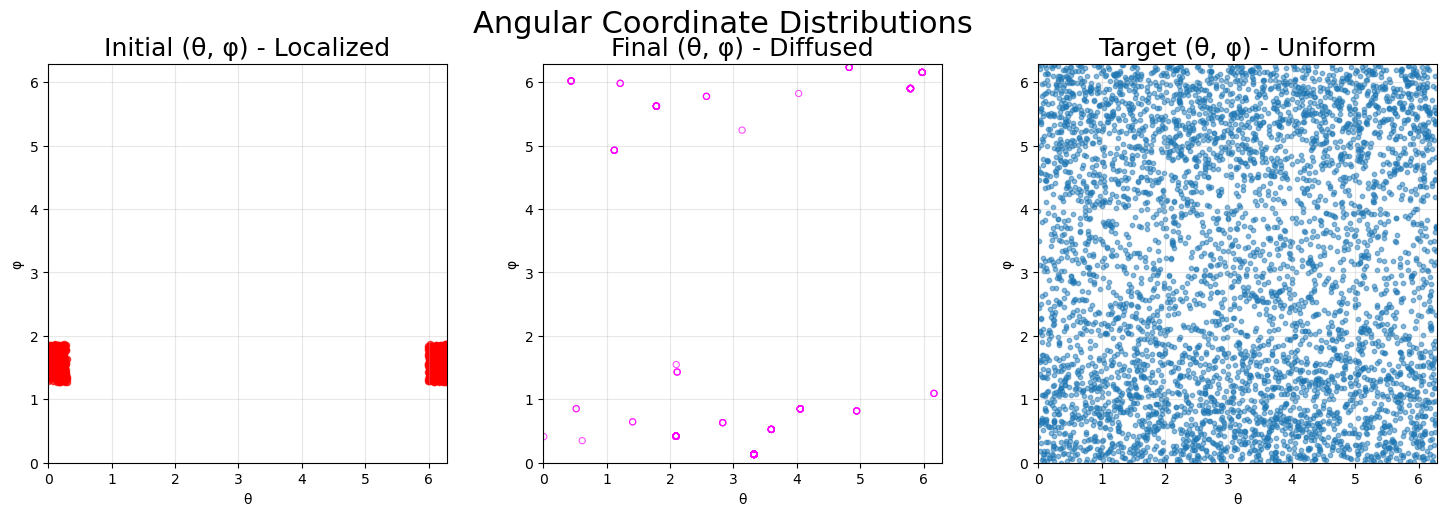


[SPREAD ANALYSIS]
Initial θ: mean=3.272, std=2.991
Final θ:   mean=3.309, std=1.053
Initial φ: mean=1.578, std=0.177
Final φ:   mean=1.117, std=2.046


c:\Users\xyc93\miniconda3\envs\gpu\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning:

invalid value encountered in divide



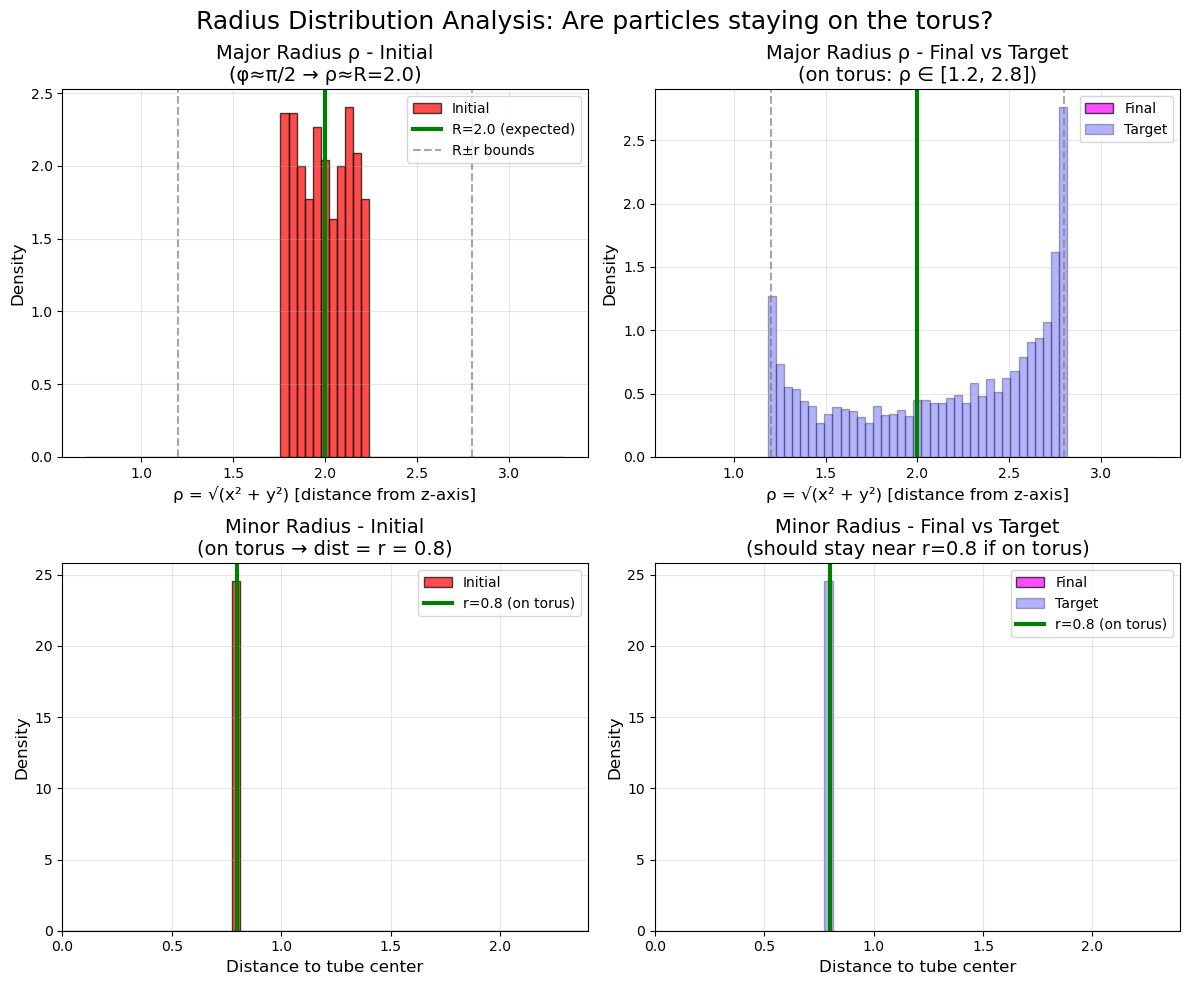


[RADIUS ANALYSIS] - Key metric: do particles stay on torus surface?

1. Major radius ρ = √(x²+y²) [distance from z-axis]:
   On torus surface: ρ ∈ [R-r, R+r] = [1.20, 2.80]
   Initial (φ≈π/2 → ρ≈R): mean=1.9941, std=0.1405
   Final:                  mean=169.0985, std=107.4327
   Target:                 mean=2.1640, std=0.5449

2. Minor radius [distance to tube center]:
   On torus surface: dist = r = 0.80 (exactly!)
   Initial:  mean=0.8000, std=0.000000
   Final:    mean=222.0264, std=444.3878
   Target:   mean=0.8000, std=0.000000

[TORUS CHECK]
   Initial particles off torus (|dist-r|>0.01): 0/500 (0.0%)
   Final particles off torus (|dist-r|>0.1):    500/500 (100.0%)


In [20]:
# Convert initial and final positions to angular coordinates
theta_init_final, phi_init_final = cartesian_to_angles(x_t[:, :, 0], R, r)
theta_final, phi_final = cartesian_to_angles(x_t[:, :, -1], R, r)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Initial distribution in angular coordinates
axes[0].scatter(theta_init_final, phi_init_final, s=20, c='red', alpha=0.7)
axes[0].set_xlabel('θ')
axes[0].set_ylabel('φ')
axes[0].set_title('Initial (θ, φ) - Localized', fontsize=18)
axes[0].set_xlim(0, 2*np.pi)
axes[0].set_ylim(0, 2*np.pi)
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

# Final distribution in angular coordinates
axes[1].scatter(theta_final, phi_final, s=20, facecolors='none', edgecolors='magenta', linewidths=0.8, alpha=0.7)
axes[1].set_xlabel('θ')
axes[1].set_ylabel('φ')
axes[1].set_title('Final (θ, φ) - Diffused', fontsize=18)
axes[1].set_xlim(0, 2*np.pi)
axes[1].set_ylim(0, 2*np.pi)
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

# Target distribution in angular coordinates
axes[2].scatter(theta_tar, phi_tar, s=10, c='C0', alpha=0.5)
axes[2].set_xlabel('θ')
axes[2].set_ylabel('φ')
axes[2].set_title('Target (θ, φ) - Uniform', fontsize=18)
axes[2].set_xlim(0, 2*np.pi)
axes[2].set_ylim(0, 2*np.pi)
axes[2].set_aspect('equal')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Angular Coordinate Distributions', fontsize=22)
plt.tight_layout()
plt.show()

# Compute spread statistics
print("\n[SPREAD ANALYSIS]")
print(f"Initial θ: mean={np.mean(theta_init_final):.3f}, std={np.std(theta_init_final):.3f}")
print(f"Final θ:   mean={np.mean(theta_final):.3f}, std={np.std(theta_final):.3f}")
print(f"Initial φ: mean={np.mean(phi_init_final):.3f}, std={np.std(phi_init_final):.3f}")
print(f"Final φ:   mean={np.mean(phi_final):.3f}, std={np.std(phi_final):.3f}")

# ============ Figure 4: Radius Analysis ============
# Compute radii for initial and final positions
# Major radius ρ = sqrt(x² + y²) is distance from z-axis
# Minor radius = distance from tube center (should be exactly r on torus surface)

# Initial positions
x_init_pos = x_t[:, 0, 0]
y_init_pos = x_t[:, 1, 0]
z_init_pos = x_t[:, 2, 0]
rho_init = np.sqrt(x_init_pos**2 + y_init_pos**2)  # Distance from z-axis (major radius)
dist_to_tube_center_init = np.sqrt((rho_init - R)**2 + z_init_pos**2)  # Minor radius

# Final positions
x_final_pos = x_t[:, 0, -1]
y_final_pos = x_t[:, 1, -1]
z_final_pos = x_t[:, 2, -1]
rho_final = np.sqrt(x_final_pos**2 + y_final_pos**2)  # Distance from z-axis (major radius)
dist_to_tube_center_final = np.sqrt((rho_final - R)**2 + z_final_pos**2)  # Minor radius

# Target positions for reference
rho_tar = np.sqrt(X_tar[:, 0]**2 + X_tar[:, 1]**2)
dist_to_tube_center_tar = np.sqrt((rho_tar - R)**2 + X_tar[:, 2]**2)

# Create 2x2 figure for radius distributions
fig_rad, axes_rad = plt.subplots(2, 2, figsize=(12, 10))

# ===== Row 1: Major radius ρ (distance from z-axis) =====
# Initial: since φ≈π/2, we have cos(φ)≈0, so ρ = R + r*cos(φ) ≈ R = 2.0
rho_bins = np.linspace(R - r - 0.5, R + r + 0.5, 60)

# Plot 1: Major radius ρ - Initial (should be delta-like at ρ≈R since φ≈π/2)
axes_rad[0, 0].hist(rho_init, bins=rho_bins, color='red', alpha=0.7, edgecolor='black', density=True, label='Initial')
axes_rad[0, 0].axvline(R, color='green', linestyle='-', linewidth=3, label=f'R={R:.1f} (expected)')
axes_rad[0, 0].axvline(R - r, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label=f'R±r bounds')
axes_rad[0, 0].axvline(R + r, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
axes_rad[0, 0].set_xlabel('ρ = √(x² + y²) [distance from z-axis]', fontsize=12)
axes_rad[0, 0].set_ylabel('Density', fontsize=12)
axes_rad[0, 0].set_title(f'Major Radius ρ - Initial\n(φ≈π/2 → ρ≈R={R})', fontsize=14)
axes_rad[0, 0].legend(fontsize=10)
axes_rad[0, 0].grid(True, alpha=0.3)

# Plot 2: Major radius ρ - Final
axes_rad[0, 1].hist(rho_final, bins=rho_bins, color='magenta', alpha=0.7, edgecolor='black', density=True, label='Final')
axes_rad[0, 1].hist(rho_tar, bins=rho_bins, color='blue', alpha=0.3, edgecolor='black', density=True, label='Target')
axes_rad[0, 1].axvline(R, color='green', linestyle='-', linewidth=3)
axes_rad[0, 1].axvline(R - r, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
axes_rad[0, 1].axvline(R + r, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
axes_rad[0, 1].set_xlabel('ρ = √(x² + y²) [distance from z-axis]', fontsize=12)
axes_rad[0, 1].set_ylabel('Density', fontsize=12)
axes_rad[0, 1].set_title(f'Major Radius ρ - Final vs Target\n(on torus: ρ ∈ [{R-r}, {R+r}])', fontsize=14)
axes_rad[0, 1].legend(fontsize=10)
axes_rad[0, 1].grid(True, alpha=0.3)

# ===== Row 2: Minor radius (distance to tube center) =====
# On torus surface, this should be exactly r = 0.8
minor_bins = np.linspace(0, r * 3, 60)

# Plot 3: Minor radius - Initial (should be delta-like at r=0.8)
axes_rad[1, 0].hist(dist_to_tube_center_init, bins=minor_bins, color='red', alpha=0.7, edgecolor='black', density=True, label='Initial')
axes_rad[1, 0].axvline(r, color='green', linestyle='-', linewidth=3, label=f'r={r:.1f} (on torus)')
axes_rad[1, 0].set_xlabel('Distance to tube center', fontsize=12)
axes_rad[1, 0].set_ylabel('Density', fontsize=12)
axes_rad[1, 0].set_title(f'Minor Radius - Initial\n(on torus → dist = r = {r})', fontsize=14)
axes_rad[1, 0].legend(fontsize=10)
axes_rad[1, 0].grid(True, alpha=0.3)
axes_rad[1, 0].set_xlim(0, r * 3)

# Plot 4: Minor radius - Final (should still be near r=0.8 if KSWGD works)
axes_rad[1, 1].hist(dist_to_tube_center_final, bins=minor_bins, color='magenta', alpha=0.7, edgecolor='black', density=True, label='Final')
axes_rad[1, 1].hist(dist_to_tube_center_tar, bins=minor_bins, color='blue', alpha=0.3, edgecolor='black', density=True, label='Target')
axes_rad[1, 1].axvline(r, color='green', linestyle='-', linewidth=3, label=f'r={r:.1f} (on torus)')
axes_rad[1, 1].set_xlabel('Distance to tube center', fontsize=12)
axes_rad[1, 1].set_ylabel('Density', fontsize=12)
axes_rad[1, 1].set_title(f'Minor Radius - Final vs Target\n(should stay near r={r} if on torus)', fontsize=14)
axes_rad[1, 1].legend(fontsize=10)
axes_rad[1, 1].grid(True, alpha=0.3)
axes_rad[1, 1].set_xlim(0, r * 3)

plt.suptitle('Radius Distribution Analysis: Are particles staying on the torus?', fontsize=18)
plt.tight_layout()
plt.show()

# Print radius statistics
print("\n[RADIUS ANALYSIS] - Key metric: do particles stay on torus surface?")
print(f"\n1. Major radius ρ = √(x²+y²) [distance from z-axis]:")
print(f"   On torus surface: ρ ∈ [R-r, R+r] = [{R-r:.2f}, {R+r:.2f}]")
print(f"   Initial (φ≈π/2 → ρ≈R): mean={np.mean(rho_init):.4f}, std={np.std(rho_init):.4f}")
print(f"   Final:                  mean={np.mean(rho_final):.4f}, std={np.std(rho_final):.4f}")
print(f"   Target:                 mean={np.mean(rho_tar):.4f}, std={np.std(rho_tar):.4f}")

print(f"\n2. Minor radius [distance to tube center]:")
print(f"   On torus surface: dist = r = {r:.2f} (exactly!)")
print(f"   Initial:  mean={np.mean(dist_to_tube_center_init):.4f}, std={np.std(dist_to_tube_center_init):.6f}")
print(f"   Final:    mean={np.mean(dist_to_tube_center_final):.4f}, std={np.std(dist_to_tube_center_final):.4f}")
print(f"   Target:   mean={np.mean(dist_to_tube_center_tar):.4f}, std={np.std(dist_to_tube_center_tar):.6f}")

# Check if particles flew off the torus
off_torus_init = np.sum(np.abs(dist_to_tube_center_init - r) > 0.01)
off_torus_final = np.sum(np.abs(dist_to_tube_center_final - r) > 0.1)
print(f"\n[TORUS CHECK]")
print(f"   Initial particles off torus (|dist-r|>0.01): {off_torus_init}/{m} ({100*off_torus_init/m:.1f}%)")
print(f"   Final particles off torus (|dist-r|>0.1):    {off_torus_final}/{m} ({100*off_torus_final/m:.1f}%)")

## 19. Scatter Matrix Analysis (Fourier EDMD)

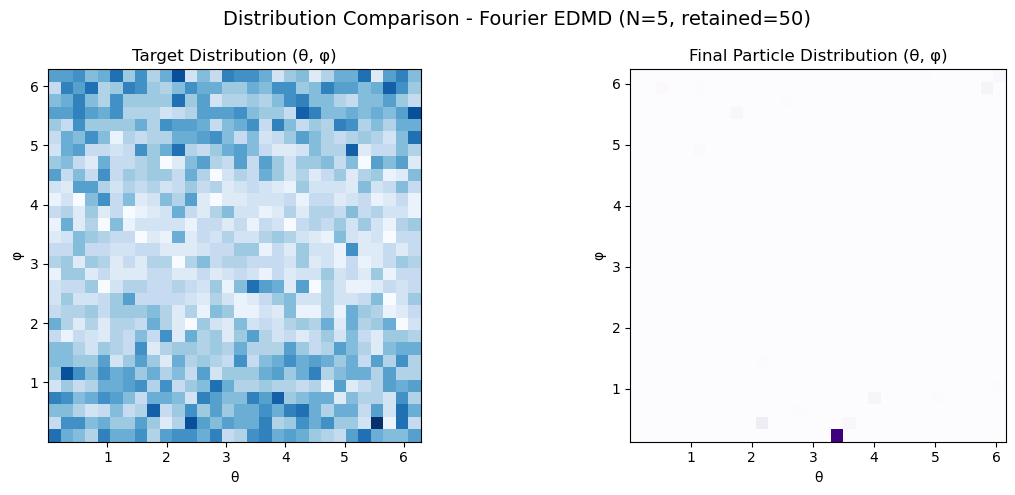

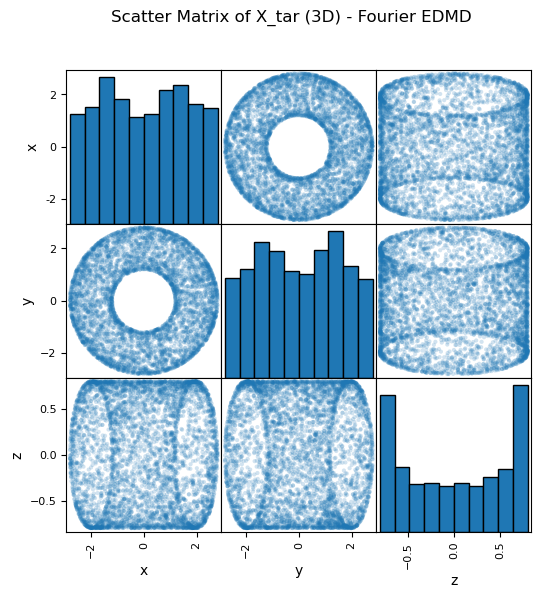

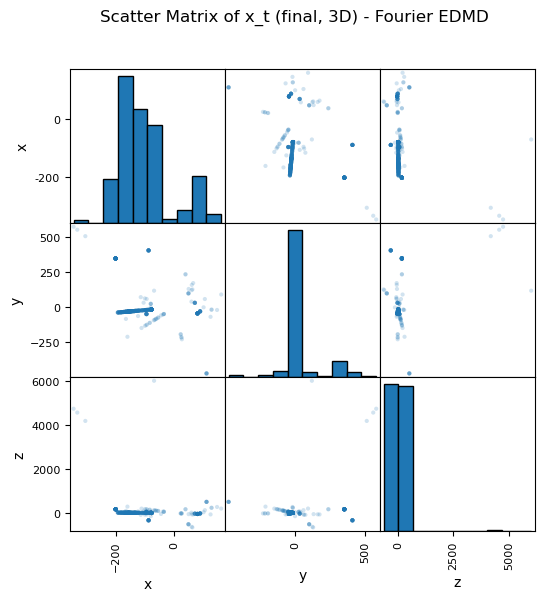

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Target distribution histogram
axes[0].hist2d(theta_tar, phi_tar, bins=30, cmap='Blues')
axes[0].set_xlabel('θ')
axes[0].set_ylabel('φ')
axes[0].set_title('Target Distribution (θ, φ)')
axes[0].set_aspect('equal')

# Final particle distribution histogram
axes[1].hist2d(theta_final, phi_final, bins=30, cmap='Purples')
axes[1].set_xlabel('θ')
axes[1].set_ylabel('φ')
axes[1].set_title('Final Particle Distribution (θ, φ)')
axes[1].set_aspect('equal')

plt.suptitle(f'Distribution Comparison - Fourier EDMD (N={N_FOURIER_MODES}, retained={n_retain_dm})', fontsize=14)
plt.tight_layout()
plt.show()

# 3D scatter matrices
pd.plotting.scatter_matrix(
    pd.DataFrame(X_tar, columns=['x', 'y', 'z']),
    alpha=0.2,
    figsize=(6, 6),
    diagonal='hist',
    hist_kwds={'edgecolor': 'black'}
)
plt.suptitle(f'Scatter Matrix of X_tar (3D) - Fourier EDMD')
plt.show()

pd.plotting.scatter_matrix(
    pd.DataFrame(x_t[:, :, -1], columns=['x', 'y', 'z']),
    alpha=0.2,
    figsize=(6, 6),
    diagonal='hist',
    hist_kwds={'edgecolor': 'black'}
)
plt.suptitle(f'Scatter Matrix of x_t (final, 3D) - Fourier EDMD')
plt.show()